In [1]:
from collections import OrderedDict
import os

from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
from tensorflow_probability import distributions

import tensorflow.keras as keras

from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

tf.keras.backend.set_floatx('float64')
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive
from datasets.femto_bearing import FEMTOBearingsDataset

import pandas as pd
from scipy.stats import kurtosis


not running in colab.


In [2]:

data_root= '/mnt/6c99ccdb-4d5e-443d-b361-8b5137623ef6/'
rootfolder_pickles='%s/Dataset/bearing_fatigue_dataset/'%data_root
npz_file='%s/Dataset/bearing_fatigue_dataset/first_stage_preproc_bearings_v2.npz'%data_root
femto_dataset = FEMTOBearingsDataset(rootfolder_pickles=rootfolder_pickles, npz_file=npz_file)

training set:
00 1 1_1 2803
03 1 1_4 1428
04 1 1_5 2463
05 1 1_6 2448
06 1 1_7 2259
07 2 2_1 911
09 2 2_3 1955
11 2 2_5 2311
15 3 3_2 1637

testing set:
16 3 3_3 434
02 1 1_3 2375


In [3]:
get_x_eid = lambda eid : femto_dataset.X[femto_dataset.eid==eid]

In [4]:
learning_set = ['1_2','1_3','1_4','1_5','2_1','2_5','2_6','3_3'] # Paper

print(learning_set)
learning_set_inds = [femto_dataset.file_suffix.index(k) for k in learning_set]
eval_inds = [f for f in femto_dataset.file_suffix if f not in learning_set]

val_set_inds = [femto_dataset.file_suffix.index(k) for k in eval_inds]
APPLY_DEFAULT_SETUP = True
if APPLY_DEFAULT_SETUP:
    femto_dataset.inds_exp_source = learning_set_inds
    femto_dataset.inds_exp_target = val_set_inds


['1_2', '1_3', '1_4', '1_5', '2_1', '2_5', '2_6', '3_3']


## Paper used for comparisson 
(acc. to Eleni's suggestion)

```

Li, Xiaochuan, et al. "Remaining useful life prediction of rolling element bearings using supervised machine learning." Energies 12.14 (2019): 2705.
```

In [5]:
# compute features (RMS and kurtosis) for segments:

In [6]:
f1_1 = np.sqrt(np.mean(np.square(femto_dataset.X[:,:,0]),-1))
f1_2 = np.sqrt(np.mean(np.square(femto_dataset.X[:,:,1]),-1))
f2_1 = kurtosis(femto_dataset.X[:,:,0],-1)
f2_2 = kurtosis(femto_dataset.X[:,:,1],-1)
f3_1 = np.min(femto_dataset.X[:,:,0],1)
f3_2 = np.min(femto_dataset.X[:,:,1],1)
f4_1 = np.max(femto_dataset.X[:,:,0],1)
f4_2 = np.max(femto_dataset.X[:,:,1],1)
f5_1 = f4_1 / f4_1
f5_2 = f4_2 / f4_2
all_feats = np.vstack([f1_1, f1_2, f2_1, f2_2, f3_1, f3_2, f4_1, f4_2, f5_1, f5_2]).T


In [7]:
feat_mean = np.mean(all_feats,0)
feat_std = np.std(all_feats,0)
all_feats_norm = (all_feats - feat_mean)/(feat_std+0.10)

## Demonstrating performance of these features with DNNs and regularized sparse regression

In [8]:
inds_training_data = np.zeros_like(femto_dataset.eid)
inds_testing_data = np.zeros_like(femto_dataset.eid)
for s in femto_dataset.inds_exp_source:
     inds_training_data[femto_dataset.eid == s] =1 

for s in femto_dataset.inds_exp_target:
     inds_testing_data[femto_dataset.eid == s] =1 
        
# pplot.plot(inds_training_data)
# pplot.plot(inds_testing_data)        

In [9]:
#pplot.plot(femto_dataset.yrem_norm)
inds_training_data.astype(bool)

array([False, False, False, ...,  True,  True,  True])

# (1) Fitting a two-layer ReLU MLP using the features:


In [44]:
USE_NLL_LOSS = True
X_train, X_test = [all_feats_norm[ii.astype(bool)] for ii in [inds_training_data, inds_testing_data]]
y_train, y_test = [femto_dataset.yrem_norm[ii.astype(bool)] for ii in [inds_training_data, inds_testing_data]]

def make_gamma_observation_mlp(last_layer_units):
    """
    Takes as input a node state and returns a gamma probability distribution
    """
    seq = keras.Sequential()
    NParams= 1;
    NSamples = 100;
    seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x)+0.001,name = "output"));
    
    def instantiate_gamma(t):
        return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])

    #seq.add()
    seq.add(            
        tfp.layers.DistributionLambda(
            make_distribution_fn = lambda t: instantiate_gamma(t),
            convert_to_tensor_fn= lambda s : s.sample(NSamples)))
    seq._set_inputs(tf.keras.layers.Input((last_layer_units,)))
    return seq


def make_mlp_model(n_layer_width = 100, dropout_rate = 0.2, activation = "relu", nll_loss = USE_NLL_LOSS):
    xin = tf.keras.layers.Input(shape = (all_feats_norm.shape[-1],), name = "input")
    yy = Dense(n_layer_width, activation = activation)(xin)
    yy = Dropout(rate = dropout_rate)(yy)
    
    if not USE_NLL_LOSS:
        yy = Dense(n_layer_width, activation = activation)(yy)
        yyout = Dense(1, name = "RUL", activation = "relu")(yy)
    else:
        yy = Dense(n_layer_width)(yy)
        yy = tf.keras.layers.LayerNormalization()(yy)
        gamma_model = make_gamma_observation_mlp(n_layer_width)
        yyout = gamma_model(yy)
        
    return tf.keras.Model(inputs = xin, outputs = yyout)

    

model = make_mlp_model()
model.summary()



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_normalization_3 (Layer (None, 100)               200       
_________________________________________________________________
sequential_4 (Sequential)    multiple                  200       
Total params: 11,600
Trainable params: 11,600
Non-trainable params: 0
_______________________________________________________

In [45]:

def point_estimate(X):
    if USE_NLL_LOSS:
        return model(X).mode()
    else:
        return model(X)

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.mape)


In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
res = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[callback])

Epoch 1/50
324/324 [==============================] - 3s 7ms/step - loss: 123.5871 - val_loss: 126.8099
Epoch 2/50
324/324 [==============================] - 2s 7ms/step - loss: 81.9548 - val_loss: 111.4688
Epoch 3/50
324/324 [==============================] - 2s 7ms/step - loss: 78.0792 - val_loss: 90.7672
Epoch 4/50
324/324 [==============================] - 2s 7ms/step - loss: 74.3694 - val_loss: 81.9393
Epoch 5/50
324/324 [==============================] - 2s 7ms/step - loss: 71.8801 - val_loss: 83.3094
Epoch 6/50
324/324 [==============================] - 2s 7ms/step - loss: 69.6512 - val_loss: 84.7034
Epoch 7/50
324/324 [==============================] - 2s 7ms/step - loss: 67.9728 - val_loss: 100.6028


Text(0.5, 1.0, 'Losses \n simple MLP + timeseries features:')

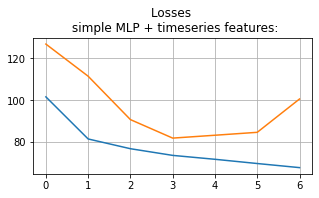

In [48]:
pplot.figure(figsize = (5,2.5))
pplot.plot(res.history['loss'], label = "training loss")
pplot.plot(res.history['val_loss'], label = "validation loss")
pplot.grid()
pplot.title("Losses \n simple MLP + timeseries features:")

# predictions for RUL on test-set:

In [49]:
# drop an index that contains a wrong entry on RUL on the first experiment:


In [50]:

y_test_hat = point_estimate(X_test)

In [51]:
y_test_hat

<tf.Tensor: shape=(13395, 1), dtype=float64, numpy=
array([[0.40962591],
       [0.42593385],
       [0.41014457],
       ...,
       [       nan],
       [       nan],
       [       nan]])>

In [52]:
y_train_hat = point_estimate(X_train)

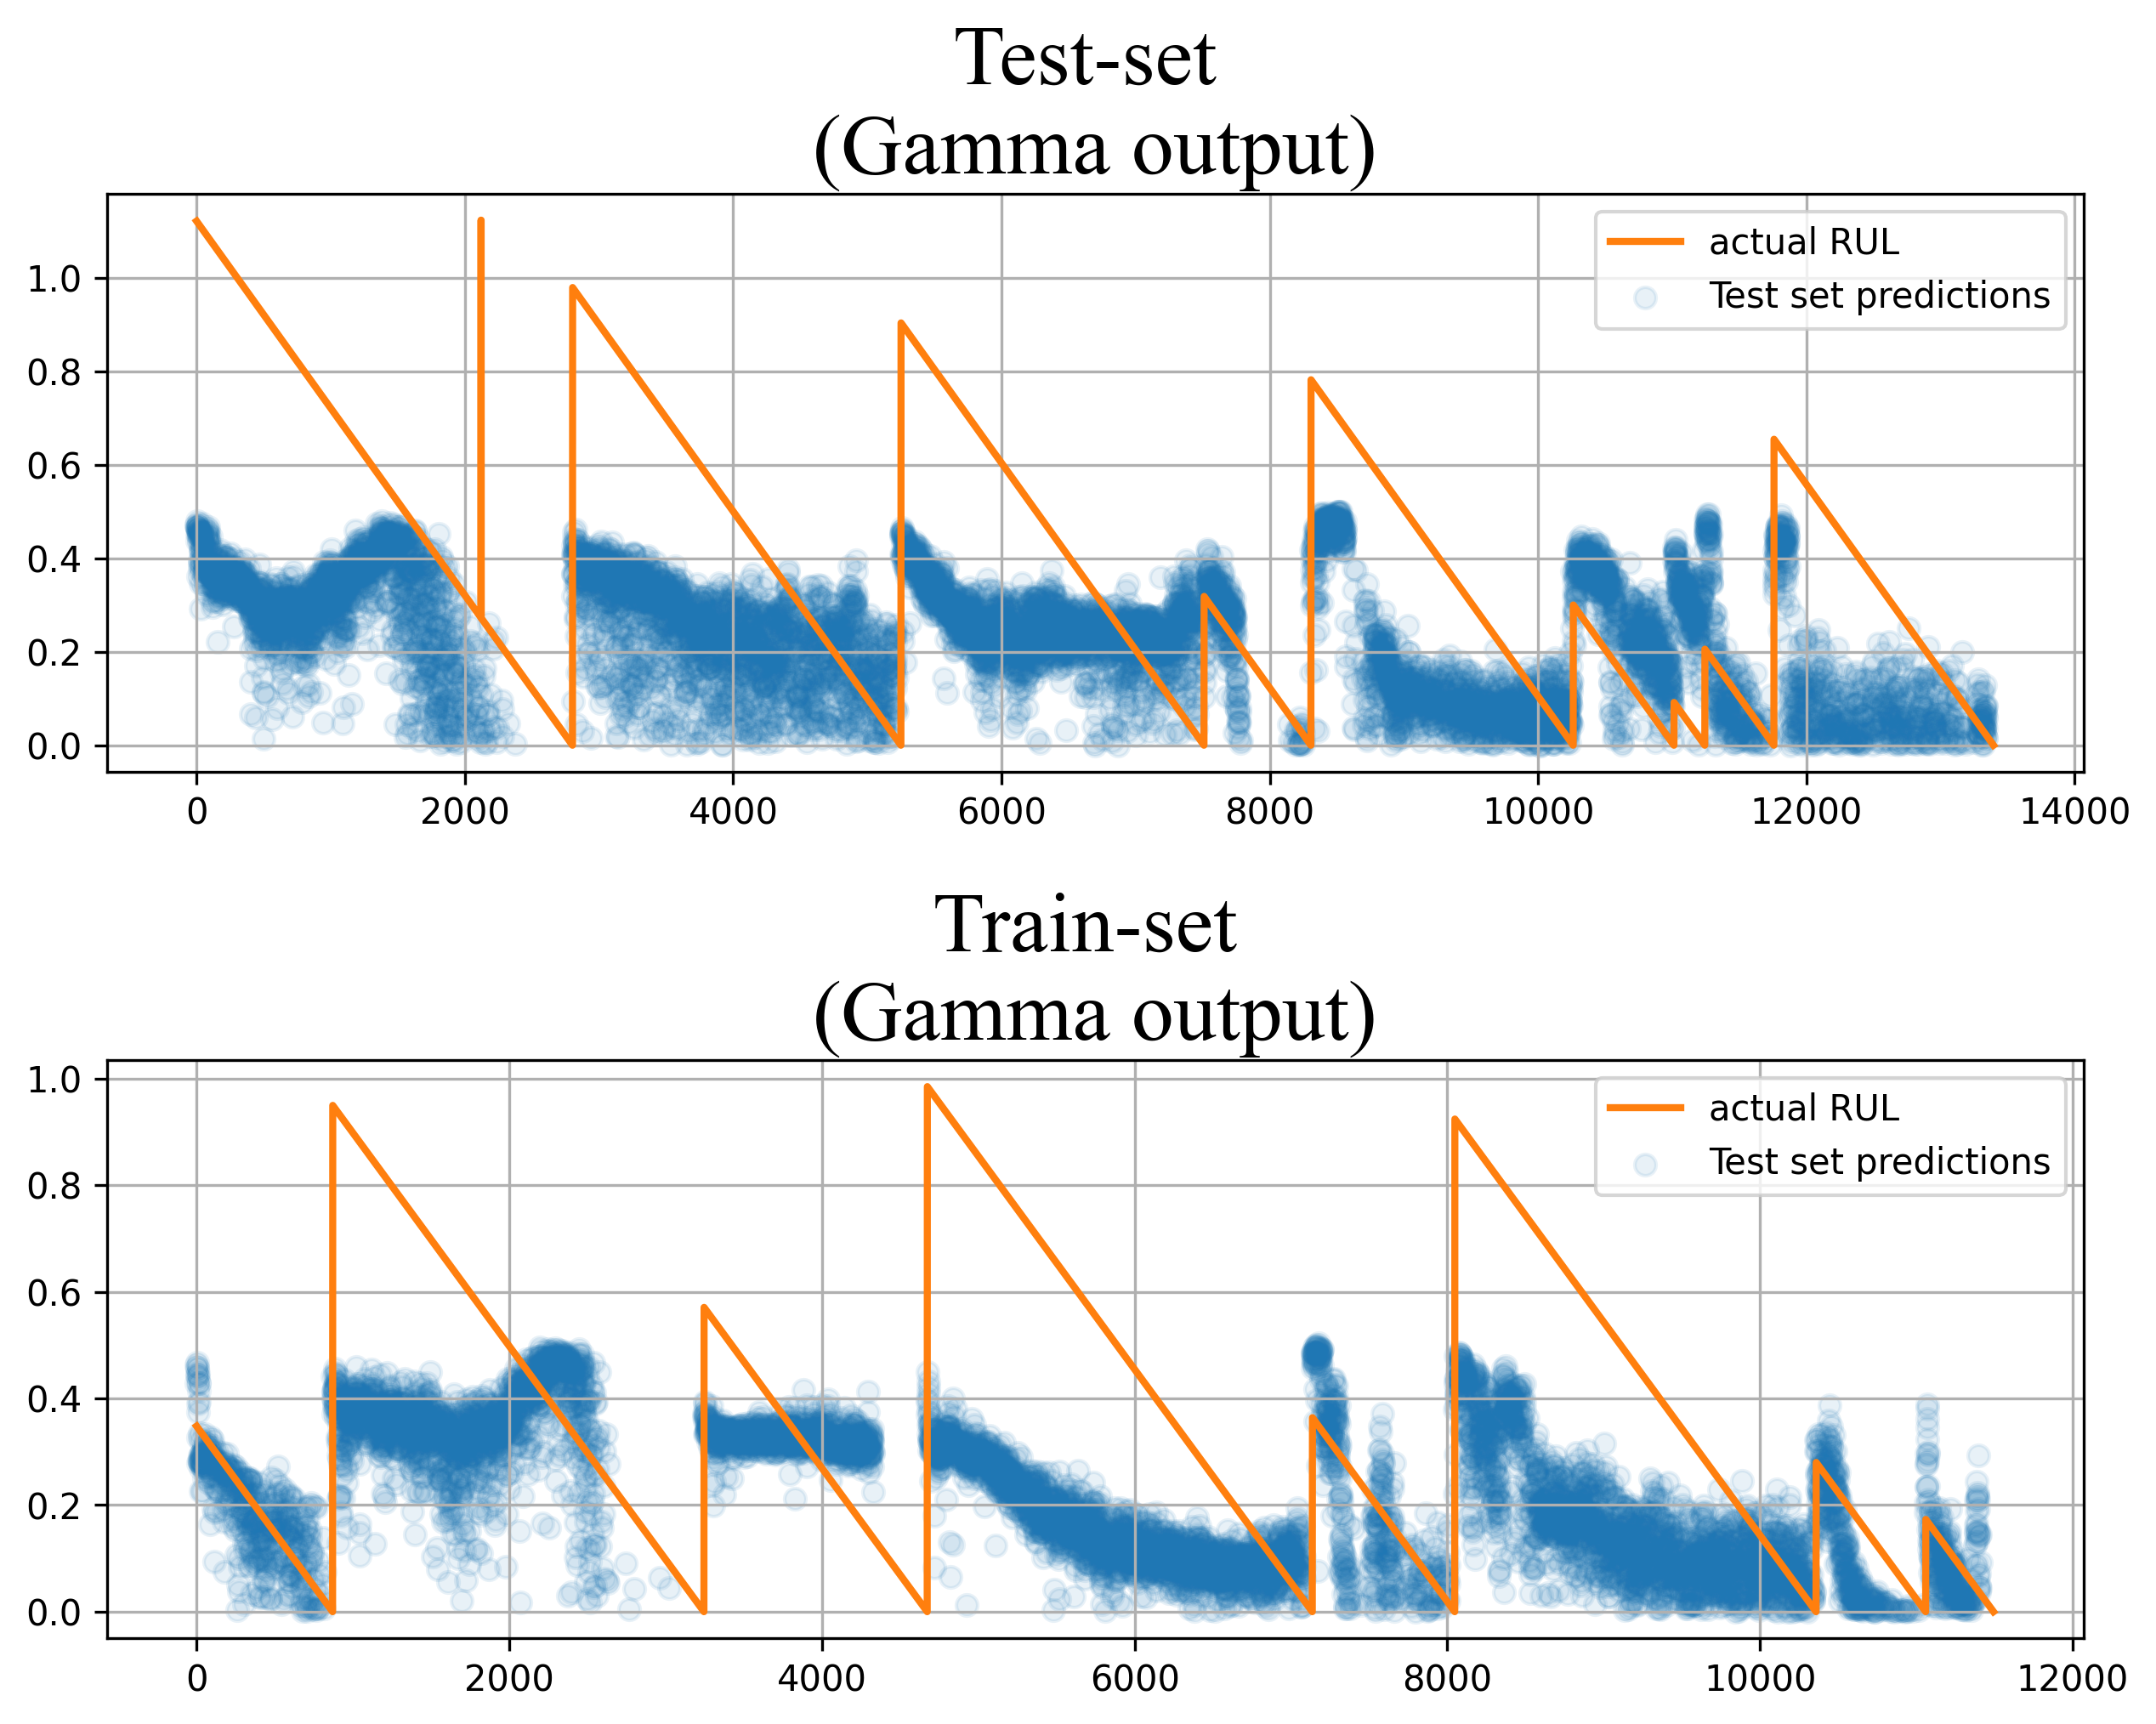

In [28]:
csfont = {'fontname':'Times New Roman','fontsize' : 24}

if USE_NLL_LOSS:
    outputnote = "(Gamma output)"
else:
    outputnote = "(ReLU output)"
    
sc = 0.5
pplot.figure(figsize = (20*sc,7.5*sc*2), dpi = 300)

pplot.subplot(2,1,1)
sc = 0.5
pplot.scatter([ i for i in range(y_test_hat.shape[0])],y_test_hat, label = "Test set predictions", alpha=0.1 )
pplot.plot(y_test, label = "actual RUL", color = "C1", linewidth = 2)

pplot.title("Test-set \n"+outputnote,**csfont)
pplot.legend()
pplot.grid()

pplot.subplot(2,1,2)
sc = 0.5
pplot.scatter([ i for i in range(y_train_hat.shape[0])],y_train_hat, label = "Test set predictions", alpha=0.1)
pplot.plot(y_train, label = "actual RUL", color = "C1", linewidth = 2, )

pplot.title("Train-set \n"+outputnote,**csfont)
pplot.legend()
pplot.grid()

pplot.subplots_adjust(hspace=0.5)
pplot.savefig("SimpleMLP_results_%s.png"%(outputnote[1:-1].replace(" ","_")))

In [1]:
mape_error_results = {}
for ee in femto_dataset.inds_exp_target:
    ee_fname = femto_dataset.file_suffix[ee]
    exp_feats = all_feats_norm[femto_dataset.eid == ee]
    point_est = point_estimate(exp_feats)
    vv= tf.keras.losses.mape(point_est, femto_dataset.yrem_norm[femto_dataset.eid == ee])
    print(np.sum(np.isnan(vv.numpy()))/vv.shape[0])
    #vv = vv[~np.isnan(vv)]
    vv[np.isnan(vv.numpy())] = np.zeros_like(vv[np.isnan(vv)])
    
    mape_error_results.update({ee_fname : tf.reduce_mean(vv).numpy()})
    
    

NameError: name 'femto_dataset' is not defined

In [42]:
vv[np.isnan(vv)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [35]:
mape_error_results

{}

MAPE_error with Gamma distr. output:
{'1_1': 393.5157,
 '1_6': 1326.322,
 '1_7': 202.48354,
 '2_2': 3780.3762,
 '2_3': 1209.4564,
 '2_4': 436.29538,
 '2_7': 101.04361,
 '3_1': 1179.9553,
 '3_2': 5478.924}
 
 
 mape_error_results - with ReLU output:
 {'1_1': 73453930.0,
 '1_6': 21591500.0,
 '1_7': 10195664.0,
 '2_2': 29763504.0,
 '2_3': 67965450.0,
 '2_4': 1597937.1,
 '2_7': 2987064.5,
 '3_1': 4790748.5,
 '3_2': 12392767.0}